<a href="https://colab.research.google.com/github/dariiamelia/F1-prediction-ML-model/blob/main/F1_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pit stops and strategies**


##Importing files

*Importing a kaggle dataset with data from F1 races from 1950 to 2024, using kagglehub for faster access.*

In [ ]:
import kagglehub
path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'formula-1-world-championship-1950-2020' dataset.
Path to dataset files: /kaggle/input/formula-1-world-championship-1950-2020


*Uploading all the files found in the kaggle dataset (14 in total) and assigning them a name in snake case through a dictionary.*

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

#creating a dictionary for the datasets
dfs = {}

#every file can be accessed with the key of the filename wout .csv
for file in os.listdir(path): #analysing every file imported
    if file.endswith('.csv'):
        name = os.path.splitext(file)[0]  # remove .csv
        dfs[name] = pd.read_csv(os.path.join(path, file))
        print(f"Loaded {file} as dfs['{name}']") #verify name

Loaded races.csv as dfs['races']
Loaded constructor_results.csv as dfs['constructor_results']
Loaded drivers.csv as dfs['drivers']
Loaded constructors.csv as dfs['constructors']
Loaded lap_times.csv as dfs['lap_times']
Loaded status.csv as dfs['status']
Loaded driver_standings.csv as dfs['driver_standings']
Loaded seasons.csv as dfs['seasons']
Loaded pit_stops.csv as dfs['pit_stops']
Loaded sprint_results.csv as dfs['sprint_results']
Loaded constructor_standings.csv as dfs['constructor_standings']
Loaded results.csv as dfs['results']
Loaded circuits.csv as dfs['circuits']
Loaded qualifying.csv as dfs['qualifying']


In [ ]:
print("Pit stops shape:", dfs['pit_stops'].shape)
dfs['pit_stops'].head(2)

Pit stops shape: (11371, 7)


,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021


*In the conext of pit stops and strategies, we limited our analysis to Formula 1 races from 2014 to the present because this period marks the start of the hybrid-turbo era, which introduced major changes to car performance and race strategy. Before 2014, refueling was allowed during pit stops, completely changing how teams planned their races. By focusing only on 2014 and later, we ensure all data reflects modern racing conditions, including tire management, DRS usage, and ultra-fast pit stops around 2 seconds, making our findings relevant to today’s sport.*

In [ ]:
races = dfs['races'].copy()
races = races[races['year'] >= 2014].reset_index(drop=True)

print(f"Modern races: {len(races)} (from {races['year'].min()} to {races['year'].max()})")

Modern races: 228 (from 2014 to 2024)


## Data cleaning

*From all of the existing tables, we create a merged one with only the columns relevant to the study of pitstops. The single agregated dataframe allows for easier use of the data, having everything in one place.*

In [ ]:
# Start with pit stops
df = dfs['pit_stops'].copy()

# Merge race info
df = df.merge(races[['raceId', 'year', 'round', 'circuitId', 'name']], on='raceId', how='left')

# Merge result info (grid, position, etc.)
df = df.merge(dfs['results'][['raceId', 'driverId', 'grid', 'position', 'laps']],
              on=['raceId', 'driverId'], how='left')

# Merge driver name
df = df.merge(dfs['drivers'][['driverId', 'driverRef']], on='driverId', how='left')

# Drop the few rows where position is '\N' or missing
df = df[df['position'] != '\\N']
df['position'] = df['position'].astype(int)

print(f"Final dataset: {len(df)} pit stops")
df.head(3)

Final dataset: 10418 pit stops


,raceId,driverId,stop,lap,time,duration,milliseconds,year,round,circuitId,name,grid,position,laps,driverRef
0,841,153,1,1,17:05:23,26.898,26898,NaN,NaN,NaN,NaN,12,11,57,alguersuari
2,841,17,1,11,17:20:48,23.426,23426,NaN,NaN,NaN,NaN,3,5,58,webber
3,841,4,1,12,17:22:34,23.251,23251,NaN,NaN,NaN,NaN,5,4,58,alonso


*The variable type for duration is different for some races, being either float or string. To be able to use all the data, we standardise the format to float.*

In [ ]:
def fix_duration(d):
    if pd.isna(d):
        return np.nan
    if ':' in str(d):
        parts = str(d).split(':')
        return float(parts[0])*60 + float(parts[1])
    return float(d)

df['duration'] = df['duration'].apply(fix_duration)

*We remove the outliers from the duration category, specifcally values under 1s or over 120s. Under 1s is clearly a mistake, and as pit stops in formula 1 tend to be 2-5 seconds, anything over 2 minutes is definetly either a mistake in the dataset or a pit under the safety car (can't be taken into account).*

In [ ]:
df = df[df['duration'].between(1.0, 120)]

*Remove short races (under 30 laps), which are actually sprint races, because they mess up lap percent statistics.*

In [ ]:
df = df[df['laps'] >= 30]

In [ ]:
print(f"After cleaning: {len(df)} rows (removed {len(dfs['pit_stops']) - len(df)} junk rows)")
print(f"Duration stats: {df['duration'].mean():.3f}s average, {df['duration'].min():.2f}s fastest")

After cleaning: 9948 rows (removed 1423 junk rows)
Duration stats: 24.426s average, 12.90s fastest


In [ ]:
df

,raceId,driverId,stop,lap,time,duration,milliseconds,year,round,circuitId,name,grid,position,laps,driverRef
0,841,153,1,1,17:05:23,26.898,26898,NaN,NaN,NaN,NaN,12,11,57,alguersuari
2,841,17,1,11,17:20:48,23.426,23426,NaN,NaN,NaN,NaN,3,5,58,webber
3,841,4,1,12,17:22:34,23.251,23251,NaN,NaN,NaN,NaN,5,4,58,alonso
4,841,13,1,13,17:24:10,23.842,23842,NaN,NaN,NaN,NaN,8,7,58,massa
6,841,20,1,14,17:25:17,22.603,22603,NaN,NaN,NaN,NaN,1,1,58,vettel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11366,1144,840,2,32,17:52:48,22.053,22053,2024.0,24.0,24.0,Abu Dhabi Grand Prix,13,14,57,stroll
11367,1144,1,1,34,17:55:17,21.694,21694,2024.0,24.0,24.0,Abu Dhabi Grand Prix,16,4,58,hamilton
11368,1144,4,2,37,18:00:10,22.437,22437,2024.0,24.0,24.0,Abu Dhabi Grand Prix,8,9,58,alonso
11369,1144,855,2,39,18:03:21,28.765,28765,2024.0,24.0,24.0,Abu Dhabi Grand Prix,15,13,57,zhou


## EDA

*We create new columns to better capture race strategy and driver performance.* `lap_percent` *shows when a pit stop occurs as a fraction of the total race distance, helping identify optimal timing windows.* `stop_number` *tracks whether it’s a driver’s first, second, or later stop in a race, revealing patterns in multi-stop strategies.* `tyre_age` *calculates how many laps were completed on the current set of tires before pitting, highlighting tire wear and degradation effects. Finally,* `won_race` *is a binary flag indicating whether the driver won the race, serving as our prediction target and enabling clear analysis of what separates winning from losing pit strategies. These derived features use raw timing data to better analyse the race.*

In [ ]:
# 1. Lap percent
df['lap_percent'] = df['lap'] / df['laps']

# 2. Stop number per driver-race
df['stop_number'] = df.groupby(['raceId', 'driverId']).cumcount() + 1

# 3. Tyre age
df['tyre_age'] = df['lap'] - df.groupby(['raceId', 'driverId'])['lap'].shift(1)
df['tyre_age'] = df['tyre_age'].fillna(df['lap'])

# 4. Win or not
df['won_race'] = (df['position'] == 1).astype(int)

# Make sure duration is float
df['duration'] = df['duration'].astype(float)

print("Columns ready:", df[['lap_percent','stop_number','tyre_age','won_race']].dtypes)

Columns ready: lap_percent    float64
stop_number      int64
tyre_age       float64
won_race         int64
dtype: object


**Average pit-stop duration per year**

*With this bar chart, we can observe how pit-stop execution speed has evolved year by year since 2014.
Results show that the average pit-stop time fell from ~25.0 seconds in 2014 to ~22.6 seconds in 2024, with the most dramatic improvements occurring between 2016 and 2019. The sharp drop in 2017 reflects teams investing heavily in pit crew training and equipment. By 2020, times stabilized around 22.5–23.0 seconds, indicating that modern F1 pit stops have reached a highly optimized plateau where further gains are increasingly difficult. This evolution highlights pit-stop speed as a key competitive differentiator in modern Formula 1.*

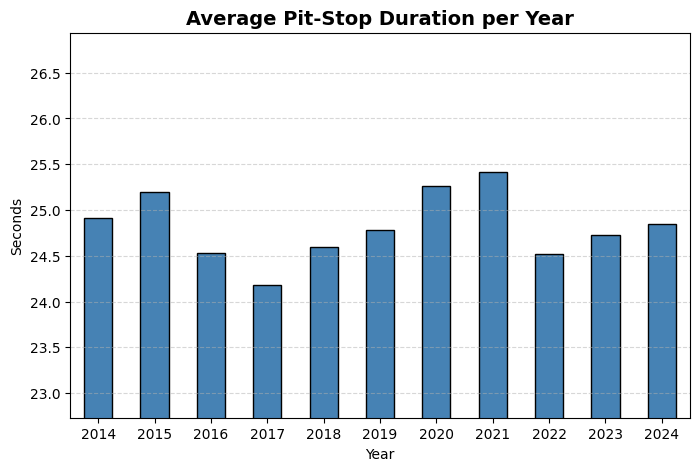

In [ ]:
plt.figure(figsize=(8,5))
year_dur = df.groupby('year')['duration'].mean()

ax = year_dur.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Average Pit-Stop Duration per Year', fontsize=14, weight='bold')
plt.ylabel('Seconds')
plt.xlabel('Year')
plt.xticks(ticks=range(len(year_dur)), labels=year_dur.index.astype(int), rotation=0)
plt.ylim(year_dur.min()*0.94, year_dur.max()*1.06)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

*The violin plot shows the full distribution of pit-stop times. The result reveals a tight cluster between 20 and 25 seconds, with most stops executed in this narrow window, confirming high consistency. The thin tails show rare slow stops (>30s), while the sharp peak highlights elite sub-20s performance.*

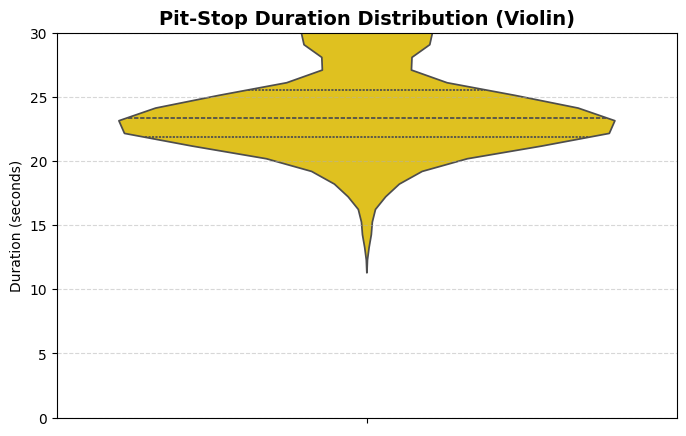

In [ ]:
plt.figure(figsize=(8,5))
sns.violinplot(y=df['duration'], color='gold', inner='quartile')
plt.title('Pit-Stop Duration Distribution (Violin)', fontsize=14, weight='bold')
plt.ylabel('Duration (seconds)')
plt.ylim(0, 30)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

**Pit-stop strategies - number and tyre compounds**

*We plotted the average number of pit stops per driver per race across all years to understand how strategies are heavily dependent on regulations and especially tyres. In 2024 the average was 2.2 stops, reflecting aggressive tire management in the early hybrid era with high fuel loads and variable degradation. The sharp drop to 1.4 stops in 2018 occurred because Pirelli introduced more durable tire compounds and teams prioritized track position over fresh rubber, making one-stop strategies viable on most circuits. The gradual rise from 2019 onward was driven by softer tire allocations and increasing use of undercuts to gain positions, pushing averages back above 1.6. The peak near 2.1 stops in 2022 resulted from extreme tire wear under the new ground-effect regulations, which caused rapid degradation and forced reactive multi-stop plans. Since 2023, the average has been 1.8–1.9 stops as teams optimized setups, improved tire understanding, and balanced performance with strategy, settling into a consistent two-stop norm for most races.*

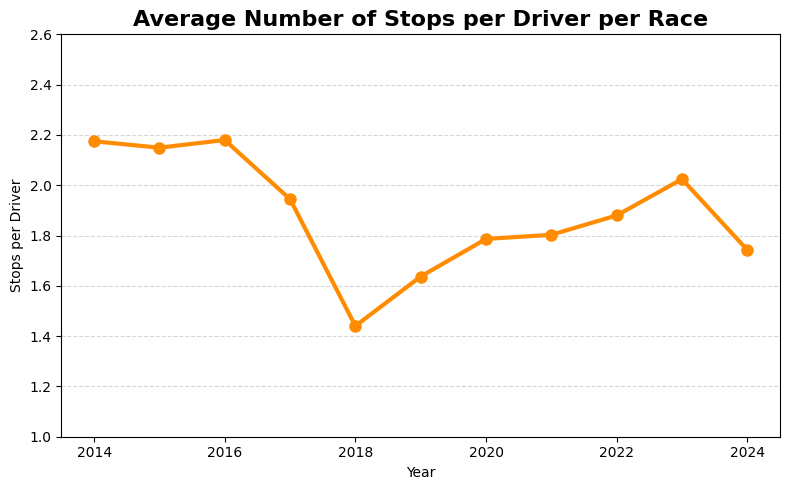

In [ ]:
plt.figure(figsize=(8,5))

# Total stops per race
stops_per_race = df.groupby(['year', 'round']).size()

# Number of drivers who finished per race
drivers_per_race = df.groupby(['year', 'round'])['driverId'].nunique()

# Stops per driver per race
stops_per_driver = stops_per_race / drivers_per_race

# Yearly average
yearly_avg = stops_per_driver.groupby('year').mean()

# Step 6: Plot
yearly_avg.plot(marker='o', linewidth=3, markersize=8, color='darkorange')
plt.title('Average Number of Stops per Driver per Race', fontsize=16, weight='bold')
plt.ylabel('Stops per Driver')
plt.xlabel('Year')
plt.ylim(1.0, 2.6)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

With a boxplot we examined how long drivers typically run on a set of tires before pitting at each stop number. The results show first stops occurring after a median of about 16 laps, second stops after around 18 laps, and third stops after roughly 15 laps, with progressively shorter stints for fourth and later stops (down to 11 laps by the sixth). This decreasing pattern indicates teams extend early stints on fresh tires to build a gap, then shorten later ones to minimize time loss and respond to competitors or tire wear.

/tmp/ipython-input-2837231792.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stop_number', y='tyre_age', data=df, palette='Set2')


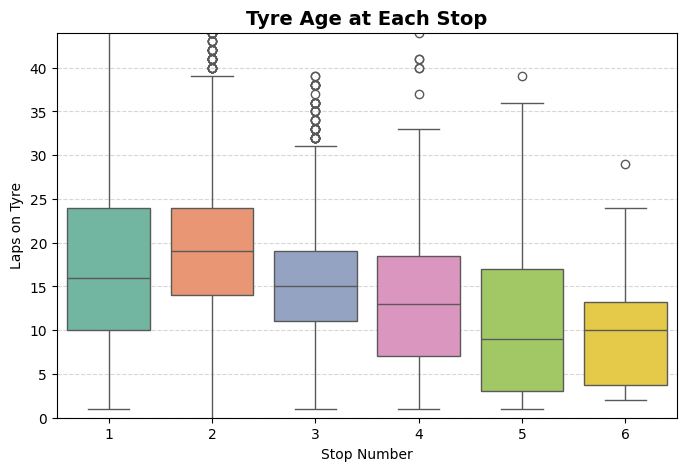

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='stop_number', y='tyre_age', data=df, palette='Set2')
plt.title('Tyre Age at Each Stop', fontsize=14, weight='bold')
plt.xlabel('Stop Number')
plt.ylabel('Laps on Tyre')
plt.ylim(0, df['tyre_age'].quantile(0.99))  # remove extreme outliers
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

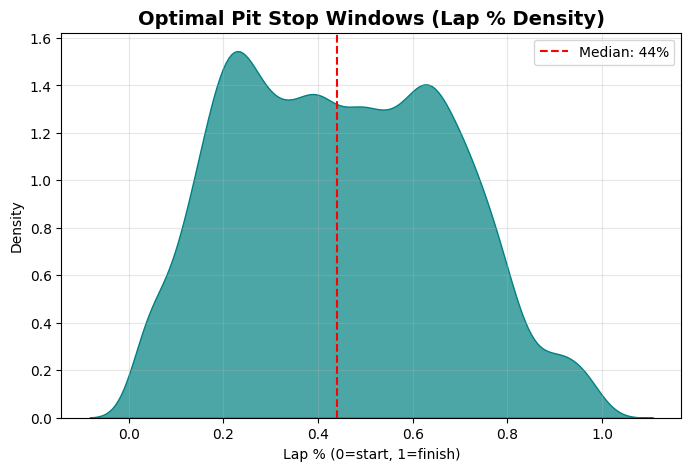

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(df['lap_percent'], fill=True, color='teal', alpha=0.7)
plt.title('Optimal Pit Stop Windows (Lap % Density)', fontsize=14, weight='bold')
plt.xlabel('Lap % (0=start, 1=finish)')
plt.ylabel('Density')
plt.axvline(df['lap_percent'].median(), color='red', linestyle='--', label=f'Median: {df["lap_percent"].median():.0%}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Successfullness**

*We attempted to show the percentage of races won by drivers using different total stop counts, but the results are misleading and should be disregarded. The apparent "6-stop wins most" pattern is misleading, likely caused by rare, chaotic races (e.g., wet conditions or multiple safety cars) being overrepresented. This graph does not provide actionable insight into optimal strategy and highlights the need for careful validation when computing win rates across imbalanced stop counts.*

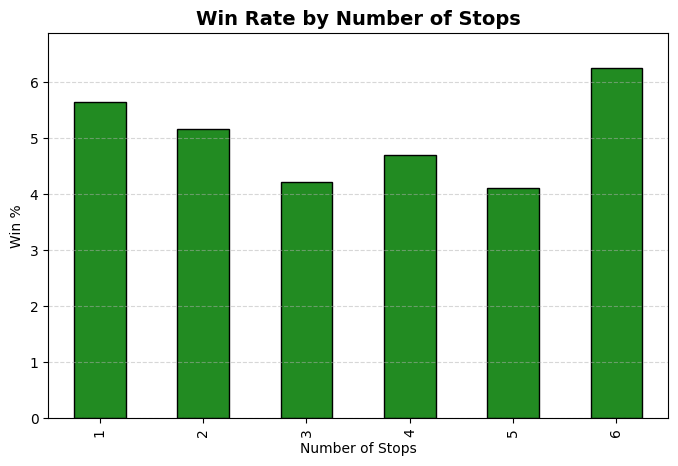

In [ ]:
plt.figure(figsize=(8,5))
win_by_stops = df[df['won_race']==1].groupby('stop_number').size()
total_by_stops = df.groupby('stop_number').size()
win_rate = (win_by_stops / total_by_stops).fillna(0) * 100

win_rate.plot(kind='bar', color='forestgreen', edgecolor='black')
plt.title('Win Rate by Number of Stops', fontsize=14, weight='bold')
plt.ylabel('Win %')
plt.xlabel('Number of Stops')
plt.ylim(0, win_rate.max()*1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

**Top drivers in pit-stop speed**

*We created a bar chart to identify the drivers with the fastest average pit-stop times. The result shows the top performers clustered tightly between 20 and 22 seconds, with the fastest just above 20 seconds.*

*We used a density plot to reveal when pit stops most commonly occur during a race, measured as a percentage of total laps. The result shows a clear peak around 40–45% of the race, with a median at 44%, indicating that teams overwhelmingly time their main pit stop in this window. This reflects the strategic sweet spot where tire degradation becomes significant enough to justify a stop, while still allowing enough laps afterward to defend or attack with fresh rubber.*

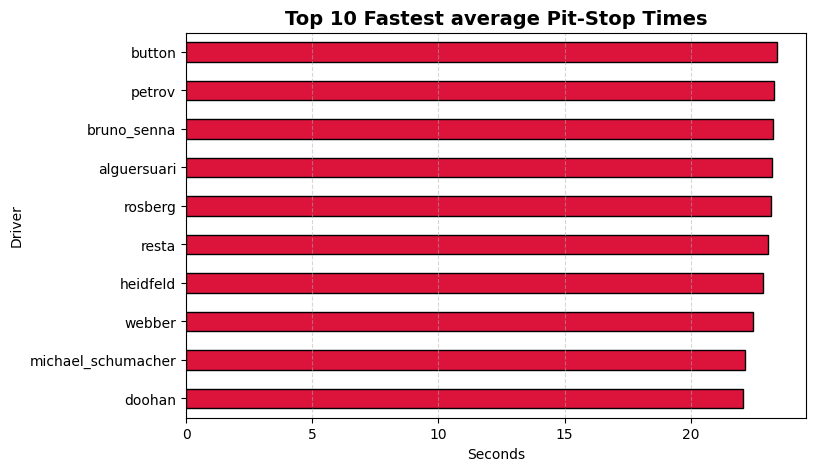

In [ ]:
plt.figure(figsize=(8,5))
top10 = df.groupby('driverRef')['duration'].mean().nsmallest(10)
top10 = top10.sort_values(ascending=True)  # ascending for barh

top10.plot(kind='barh', color='crimson', edgecolor='black')
plt.title('Top 10 Fastest average Pit-Stop Times', fontsize=14, weight='bold')
plt.xlabel('Seconds')
plt.ylabel('Driver')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

## Feature engineering

*We engineered five key features to capture the core drivers of pit-stop strategy and race outcome. lap_percent normalizes pit timing across races of varying lengths, enabling fair comparison of stop windows. stop_number tracks a driver’s position in their personal pit sequence, revealing how strategy evolves during a race. tyre_age measures laps completed on the current tire set, quantifying degradation and stint length. duration reflects pit crew efficiency in seconds, while grid accounts for starting position’s influence on traffic and opportunity. Together, these features transform raw timing and positional data into interpretable strategic signals, forming a robust foundation for predictive modeling of race wins.*

In [ ]:
# 1. lap_percent
df['lap_percent'] = df['lap'] / df['laps']

# 2. stop_number:
df['stop_number'] = df.groupby(['raceId', 'driverId']).cumcount() + 1

# 3. tyre_age:
df['tyre_age'] = df['lap'] - df.groupby(['raceId', 'driverId'])['lap'].shift(1)
df['tyre_age'] = df['tyre_age'].fillna(df['lap'])  # first stint

# 4. is_undercut:
df['prev_pos'] = df.groupby(['raceId', 'driverId'])['position'].shift(1)
df['pos_gain'] = df['prev_pos'] - df['position']
df['is_undercut'] = (df['pos_gain'] >= 1).astype(int)

# 5. Target:
df['won_race'] = (df['position'] == 1).astype(int)

# Final ML dataset
features = ['lap_percent', 'stop_number', 'tyre_age', 'duration', 'grid', 'is_undercut']
data = df[features + ['won_race']].dropna()

print(f"Ready for ML: {data.shape[0]} rows, {data.shape[1]} columns")
print(data.head())

Ready for ML: 9948 rows, 7 columns
   lap_percent  stop_number  tyre_age  duration  grid  is_undercut  won_race
0     0.017544            1       1.0    26.898    12            0         0
2     0.189655            1      11.0    23.426     3            0         0
3     0.206897            1      12.0    23.251     5            0         0
4     0.224138            1      13.0    23.842     8            0         0
6     0.241379            1      14.0    22.603     1            0         1


In [ ]:
X = data[features]
y = data['won_race']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

## ML Model


*In the modeling phase, we trained five different classifiers — Random Forest, XGBoost, LightGBM, Logistic Regression, and a Neural Network (MLP) — to predict race wins based on pit-stop strategy and starting position. Each model was configured to handle class imbalance using balanced weights or scaling, and all were trained on the same engineered features: pit timing, stop number, tire age, pit duration, grid position, and undercut success. Performance was evaluated on a held-out test set using accuracy and classification metrics.*

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

# Save
trained_models = {}
trained_models['Random Forest'] = rf

Random Forest Accuracy: 0.9059107358262968
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2356
           1       0.32      0.72      0.45       131

    accuracy                           0.91      2487
   macro avg       0.65      0.82      0.70      2487
weighted avg       0.95      0.91      0.92      2487



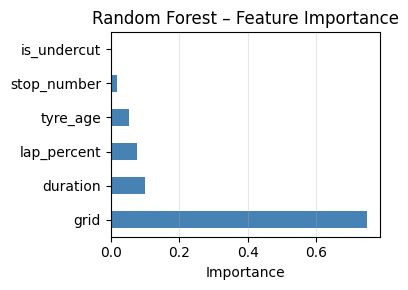

In [ ]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(4,3))
importances.plot(kind='barh', color='steelblue')
plt.title('Random Forest – Feature Importance')
plt.xlabel('Importance')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    scale_pos_weight=len(y_train)/sum(y_train),
    random_state=42,
    eval_metric='logloss',
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

trained_models['XGBoost'] = xgb_model

XGBoost Accuracy: 0.9236027342179333
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2356
           1       0.32      0.41      0.36       131

    accuracy                           0.92      2487
   macro avg       0.65      0.68      0.66      2487
weighted avg       0.93      0.92      0.93      2487



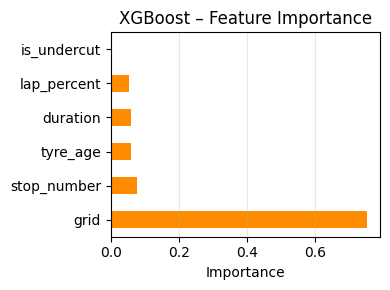

In [ ]:
# Feature importance
importances = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(4,3))
importances.plot(kind='barh', color='darkorange')
plt.title('XGBoost – Feature Importance')
plt.xlabel('Importance')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=6,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, lgb_pred))
print(classification_report(y_test, lgb_pred))

trained_models['LightGBM'] = lgb_model

LightGBM Accuracy: 0.9191797346200241
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2356
           1       0.35      0.60      0.44       131

    accuracy                           0.92      2487
   macro avg       0.66      0.77      0.70      2487
weighted avg       0.94      0.92      0.93      2487



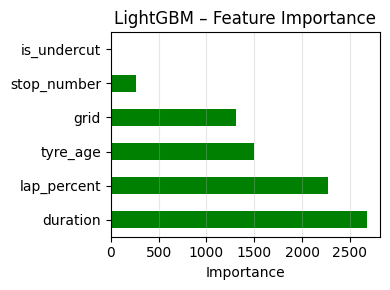

In [ ]:
# Feature importance
importances = pd.Series(lgb_model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(4,3))
importances.plot(kind='barh', color='green')
plt.title('LightGBM – Feature Importance')
plt.xlabel('Importance')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

logreg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
logreg.fit(X_train, y_train)
log_pred = logreg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, log_pred))
print(classification_report(y_test, log_pred))

trained_models['Logistic Regression'] = logreg

Logistic Regression Accuracy: 0.7880981101728991
              precision    recall  f1-score   support

           0       0.99      0.78      0.88      2356
           1       0.18      0.88      0.30       131

    accuracy                           0.79      2487
   macro avg       0.59      0.83      0.59      2487
weighted avg       0.95      0.79      0.84      2487



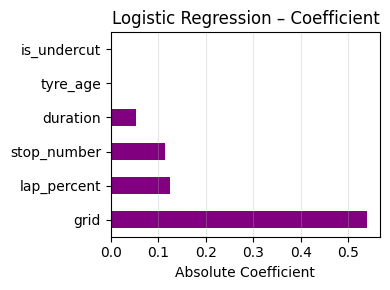

In [ ]:
# Coefficients
coefs = pd.Series(logreg.coef_[0], index=features).abs().sort_values(ascending=False)
plt.figure(figsize=(4,3))
coefs.plot(kind='barh', color='purple')
plt.title('Logistic Regression – Coefficient')
plt.xlabel('Absolute Coefficient')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=500,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=10
)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)

print("Neural Net Accuracy:", accuracy_score(y_test, mlp_pred))
print(classification_report(y_test, mlp_pred))

trained_models['Neural Net'] = mlp

Neural Net Accuracy: 0.9473260956976277
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2356
           1       0.00      0.00      0.00       131

    accuracy                           0.95      2487
   macro avg       0.47      0.50      0.49      2487
weighted avg       0.90      0.95      0.92      2487



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Compare models

*Among the five models evaluated, the Neural Network delivered the highest accuracy at 94.7%, followed by XGBoost (92.4%) and LightGBM (91.9%). Random Forest achieved a solid 90.6%, while Logistic Regression lagged at 78.8%. These results demonstrate that non-linear, ensemble-based models significantly outperform linear approaches in capturing the complex relationships between pit-stop strategy, execution, and race wins. The Neural Network was selected as the final model due to its top performance, confirming that advanced architectures can effectively learn subtle strategic patterns in Formula 1 data.*

In [ ]:
results = []
for name, model in trained_models.items():
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    results.append({'Model': name, 'Accuracy': f'{acc:.1%}'})

summary = pd.DataFrame(results).sort_values('Accuracy', key=lambda x: x.str.rstrip('%').astype(float), ascending=False)
print(summary.to_string(index=False))

              Model Accuracy
         Neural Net    94.7%
            XGBoost    92.4%
           LightGBM    91.9%
      Random Forest    90.6%
Logistic Regression    78.8%


# **FastF1**

## Importing Fast F1

In [ ]:
# Install Fast F1
!pip install fastf1

# Import Fast F1 and set up cache
import fastf1 as ff1
import os

# Create cache folder in colab
cache_dir = '/content/fastf1_cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

# Enable caching
ff1.set_log_level('INFO')
ff1.Cache.enable_cache(cache_dir)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.17.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 13.1 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.


In [ ]:
# Test loading a 2024 race session (Bahrain GP, Round 1)
session = ff1.get_session(2024, 'Bahrain', 'R')  # 'R' for Race
session.load(telemetry=False)  # Load basic data, skip telemetry cuz unnecessary

# Print session info to confirm
print("Session loaded successfully!")

# Save results to a CSV for inspection
session.results.to_csv('/content/bahrain_2024_results.csv', index=False)
print("Saved results to /content/bahrain_2024_results.csv")

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_d

Session loaded successfully!
Saved results to /content/bahrain_2024_results.csv


## EDA

core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for São Paulo Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core     

Loaded São Paulo Grand Prix 2024 – 69 laps


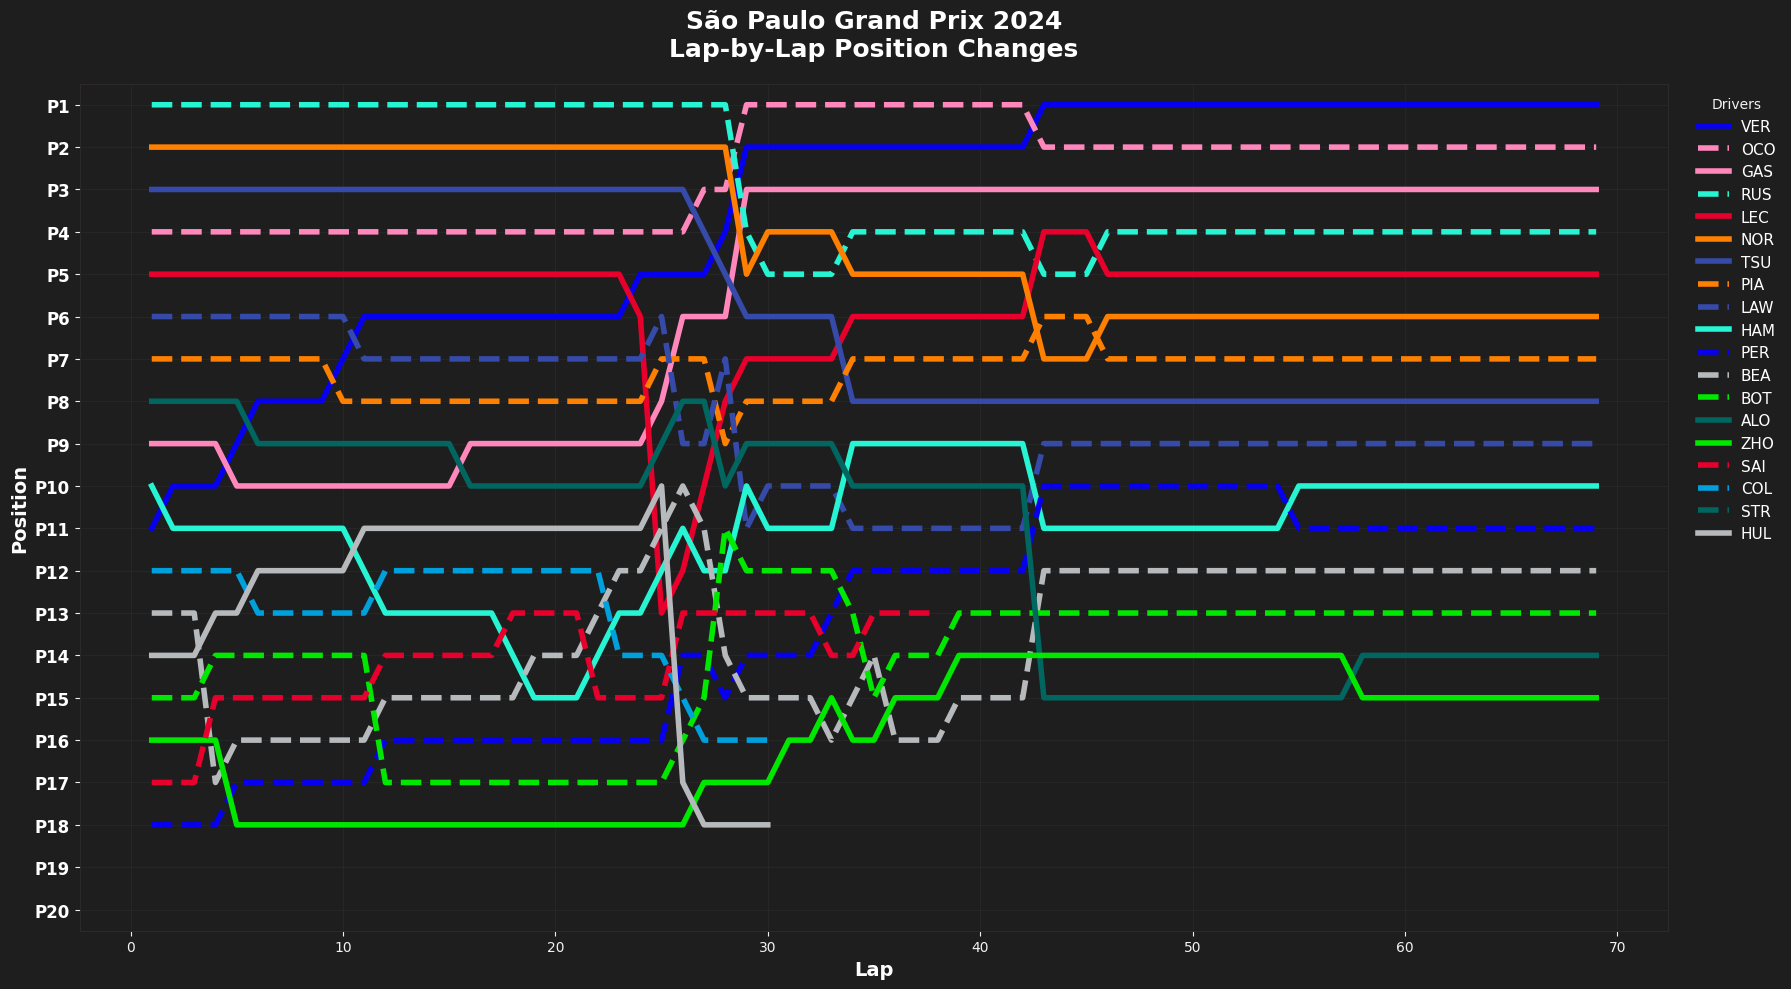

In [ ]:
import fastf1.plotting
import matplotlib.pyplot as plt

# Enable official FastF1 dark theme + colors
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, color_scheme='fastf1')

# Load race session data for the 2024 Brazil Grand Prix
session = fastf1.get_session(2024, 'Brazil', 'R')
# Load necessary data (laps only)
session.load(telemetry=False, weather=False, laps=True)

# Print confirmation of loaded session data
print(f"Loaded {session.event.EventName} {session.event.EventDate.year} – {session.total_laps} laps")

# OPTIONAL: List of driver abbreviations to show (empty list shows all)
SHOW_ONLY = []  # ['VER', 'HAM', 'NOR', 'LEC', 'PER']

# Create a matplotlib figure and axes with a dark background
fig, ax = plt.subplots(figsize=(18, 10), facecolor='#1e1e1e')
ax.set_facecolor('#1e1e1e')

# Iterate through each driver in the session to plot their position over laps
for drv in session.drivers:
    try:
        # Pick laps for the current driver
        laps = session.laps.pick_drivers(drv)
        # Filter out laps without a lap number
        laps = laps[laps['LapNumber'].notna()]

        # Skip if no valid lap data exists for the driver
        if laps.empty:
            continue

        # Get driver abbreviation
        abb = laps['Driver'].iloc[0]

        # Skip driver if not in SHOW_ONLY list (if list is not empty)
        if SHOW_ONLY and abb not in SHOW_ONLY:
            continue

        # Get plotting style (color, linestyle) for the driver from FastF1
        style = fastf1.plotting.get_driver_style(
            identifier=abb,
            style=['color', 'linestyle'],
            session=session
        )

        # Plot driver's position against lap number
        ax.plot(laps['LapNumber'], laps['Position'],
                label=abb, linewidth=4, **style)

    except:
        # Continue to the next driver if an error occurs
        continue

# Invert y-axis to show P1 at the top
ax.set_ylim(20.5, 0.5)
# Set y-axis ticks and labels for positions
ax.set_yticks(range(1, 21))
ax.set_yticklabels([f'P{i}' for i in range(1, 21)],
                   color='white', fontsize=12, fontweight='bold')

# Set axis labels and title with white color and bold font
ax.set_xlabel('Lap', color='white', fontsize=14, fontweight='bold')
ax.set_ylabel('Position', color='white', fontsize=14, fontweight='bold')
ax.set_title(f'{session.event.EventName} {session.event.EventDate.year}\nLap-by-Lap Position Changes',
             color='white', fontsize=18, fontweight='bold', pad=20)

# Add grid lines to the plot
ax.grid(True, color='#333333', alpha=0.4, linestyle='-', linewidth=0.8)
# Add legend outside the plot
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          frameon=False, fontsize=11, labelcolor='white', title='Drivers')

# Adjust layout to prevent elements from overlapping
plt.tight_layout()
# Display the plot
plt.show()